In [1]:
## System
import sys
import os
from collections import defaultdict
import itertools

## Pandas
import pandas as pd
import numpy as np

## Stats
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
import scipy.stats as stats
from scipy.stats import ttest_ind

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Fig utils 
from fig_utils import get_score_bin

In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
ConSplice_df = pd.read_csv(genic_consplice_file, sep = "\t", index_col = False)

In [5]:
## Remove subversion on gene id
ConSplice_df["gene_id"] = ConSplice_df.gene_id.apply(lambda x: x.strip().split(".")[0])

In [6]:
## Convert info to dict
by_gene_ConSplice_scores = ConSplice_df[["gene_id","max_exon_number","cds_exon_count",consplice_col]].set_index("gene_id").transpose().to_dict()

In [7]:
## Load VG values
vg_df = pd.read_csv("../data/Vg.gene_level.ANEVA_tableS1.weighted_harmonic_mean.txt", header = 1, sep="\t", index_col = False)

In [8]:
## Add ConSpliec scores to VG values by gene
vg_df["constraint_percentile"] = vg_df.apply(lambda x: by_gene_ConSplice_scores[x["#GeneID"]][consplice_col] if x["#GeneID"] in by_gene_ConSplice_scores else -0.1, axis = 1)
vg_df["max_exon_number"] = vg_df.apply(lambda x: by_gene_ConSplice_scores[x["#GeneID"]]["max_exon_number"] if x["#GeneID"] in by_gene_ConSplice_scores else -0.1, axis = 1)
vg_df["cds_exon_count"] = vg_df.apply(lambda x: by_gene_ConSplice_scores[x["#GeneID"]]["cds_exon_count"] if x["#GeneID"] in by_gene_ConSplice_scores else -0.1, axis = 1)


In [9]:
## Get the splicing constarint decile for each variant
vg_df["constraint_percentile_bin"] = vg_df.apply(get_score_bin, score_column = "constraint_percentile", axis = 1)

In [10]:
## Update bin mapping for plotting
order = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]

bin_mapping = dict()
for i, b in enumerate(order):
    bin_mapping[b] = i 

bin_mapping["-1.0"] = -1.0


vg_df["constraint_percentile_bin_int"] = vg_df["constraint_percentile_bin"].apply(lambda x: bin_mapping[x])

vg_df["constraint_percentile_int"] = vg_df["constraint_percentile"] * 10

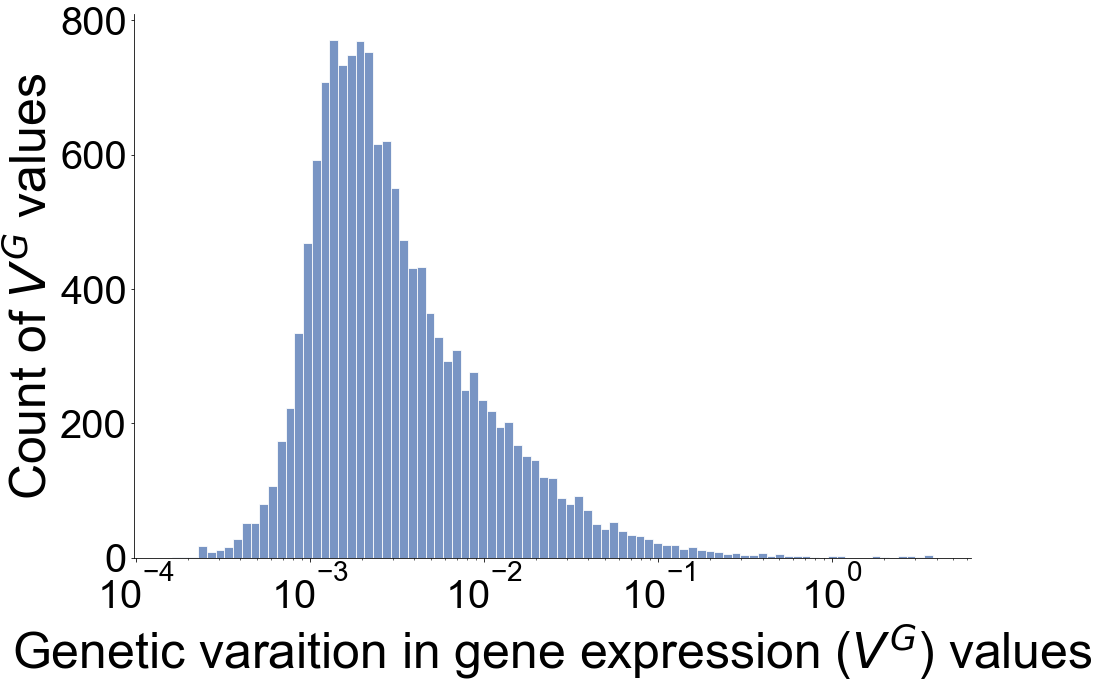

In [11]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

sns.histplot(x = "Avg_VG", data = vg_df, log_scale=True)

plt.ylabel("Count of $V^G$ values", fontsize = 50)
plt.xlabel("Genetic varaition in gene expression ($V^G$) values", fontsize = 50)
ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40) 

plt.savefig('../figures/suppl_figure5_A.svg')

In [12]:
vg_df["zscore"] = stats.zscore(vg_df.Avg_VG)

In [13]:
print("Genes with a vG value >= 10 stds from the mean: {}".format( vg_df[vg_df.zscore >= 7].shape[0]))

Genes with a vG value >= 10 stds from the mean: 20


In [14]:
## Ordinary Least Squares (OLS) Linear regression

## Remove genes with a vG value >= 10 standard deviations from the mean.

## ConSplice and max exon number 

X = vg_df.loc[(vg_df.constraint_percentile >= 0) & (vg_df.zscore < 10)].sort_values(by = "constraint_percentile_bin")[["constraint_percentile_bin_int","max_exon_number"]]
Y = vg_df.loc[(vg_df.constraint_percentile >= 0) & (vg_df.zscore < 10)].sort_values(by = "constraint_percentile_bin")["Avg_VG"]
X2 = sm.add_constant(X)

est = sm.OLS(Y, X2)

est2 = est.fit()

In [15]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Avg_VG   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     76.10
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           1.46e-33
Time:                        12:07:06   Log-Likelihood:                 27989.
No. Observations:               11647   AIC:                        -5.597e+04
Df Residuals:                   11644   BIC:                        -5.595e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [16]:
print("OLS p-value: {}".format(est2.pvalues.constraint_percentile_bin_int))

OLS p-value: 5.991785337254208e-26


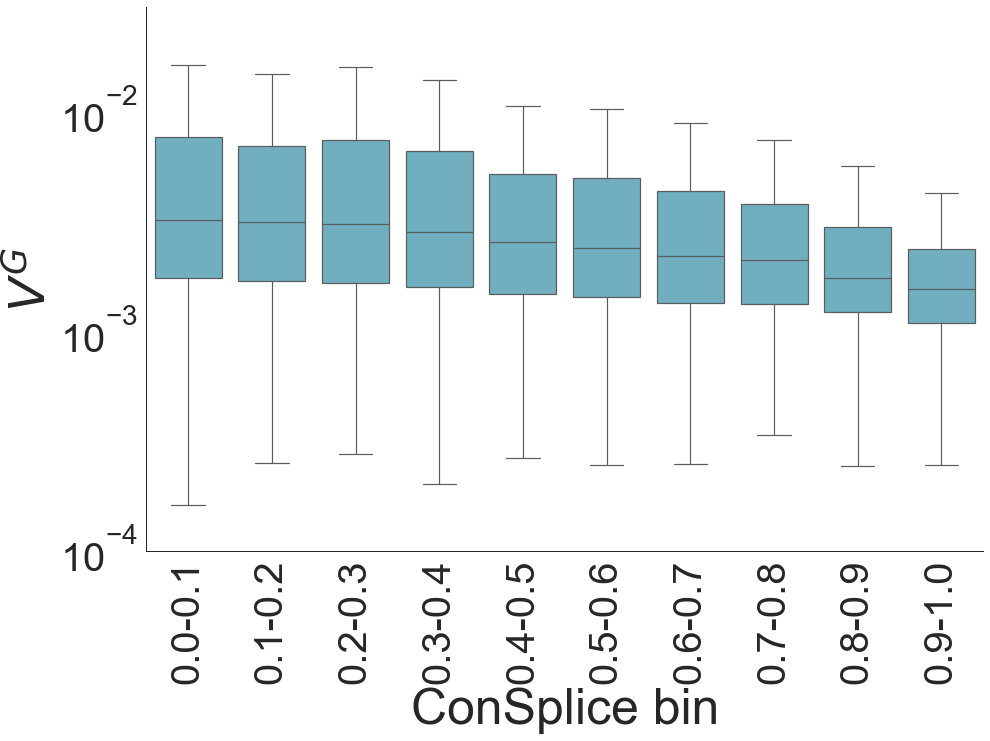

In [17]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


order = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]
box_plot = sns.boxplot(x = "constraint_percentile_bin", 
                       y = "Avg_VG", 
                       data = vg_df.loc[(vg_df.constraint_percentile >= 0) & (vg_df.Avg_VG < 1)].sort_values(by = "constraint_percentile_bin"),
                       order = order,
                       showfliers=False,
                       color = sns.color_palette()[9],
                       ax = ax)

labels = vg_df.loc[(vg_df.constraint_percentile >= 0) & (vg_df.Avg_VG < 1)].groupby("constraint_percentile_bin").Avg_VG.count().tolist()


ax.set_yscale("log")


ax.tick_params(axis="x", labelsize=40, rotation= 90)
ax.tick_params(axis="y", labelsize=40)    

plt.ylim(0.0001, 0.03)
plt.ylabel("$V^G$", fontsize = 50)
plt.xlabel("ConSplice bin", fontsize = 50)

plt.savefig('../figures/suppl_figure5_B.svg')

In [18]:
## Pairwise T-test between each bin distribution 

## Remove genes with a vG value >= 10 standard deviations from the mean.

p_values = []
for comparison in list(itertools.combinations(order, 2)):
    value1 = comparison[0]
    value2 = comparison[1]
    stat, p = ttest_ind(vg_df.loc[(vg_df.constraint_percentile_bin == value1) & (vg_df.zscore < 10)].Avg_VG.values,
                        vg_df.loc[(vg_df.constraint_percentile_bin == value2) & (vg_df.zscore < 10)].Avg_VG.values)
    
    print("Results for {} vs {} is: stat: {}. p_value: {}".format(value1,value2, stat, p))
    
    p_values.append(p)

Results for 0.0-0.1 vs 0.1-0.2 is: stat: 1.0910186642098711. p_value: 0.2753936388970289
Results for 0.0-0.1 vs 0.2-0.3 is: stat: 2.4895899300659154. p_value: 0.012869826504065571
Results for 0.0-0.1 vs 0.3-0.4 is: stat: 0.9931646929643624. p_value: 0.32075068882734886
Results for 0.0-0.1 vs 0.4-0.5 is: stat: 3.748500101996902. p_value: 0.00018295965592744618
Results for 0.0-0.1 vs 0.5-0.6 is: stat: 4.260596486841005. p_value: 2.133125316334526e-05
Results for 0.0-0.1 vs 0.6-0.7 is: stat: 3.469718054137614. p_value: 0.0005318235782582954
Results for 0.0-0.1 vs 0.7-0.8 is: stat: 4.844557906832895. p_value: 1.3631382435379748e-06
Results for 0.0-0.1 vs 0.8-0.9 is: stat: 7.374071326708432. p_value: 2.351584818675651e-13
Results for 0.0-0.1 vs 0.9-1.0 is: stat: 8.587195831111742. p_value: 1.6440518463052968e-17
Results for 0.1-0.2 vs 0.2-0.3 is: stat: 1.2118185114417808. p_value: 0.22570537177291206
Results for 0.1-0.2 vs 0.3-0.4 is: stat: -0.027718184618478817. p_value: 0.9778893184863734

In [19]:
## FDR p-value adjustmnet 

### Benjamini-Hochberg p-value adjustment 
### Alpha value at 0.01


adjusted_pvalues = smm.multipletests(p_values, alpha = 0.01, method = "fdr_bh")
adjusted_p = adjusted_pvalues[1]

In [20]:
temp_df = pd.DataFrame(np.ones((10,10)), columns = order, index = order)

for comparison, adjusted_p_value in zip(list(itertools.combinations(order, 2)), adjusted_p):
    value1 = comparison[0]
    value2 = comparison[1]
    
    temp_df.at[value2, value1] = adjusted_p_value

In [21]:
temp_df

,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
0.0-0.1,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.0
0.1-0.2,3.098178e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.0
0.2-0.3,1.967574e-02,2.672827e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.0
0.3-0.4,3.520434e-01,9.778893e-01,2.948711e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.0
0.4-0.5,3.920564e-04,1.274776e-02,2.689254e-02,1.967574e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.0
0.5-0.6,5.646508e-05,2.870182e-03,2.357914e-03,6.348271e-03,5.961922e-01,1.000000e+00,1.000000e+00,1.000000,1.000000,1.0
0.6-0.7,1.040524e-03,1.967574e-02,7.112153e-02,2.862799e-02,9.682010e-01,5.961922e-01,1.000000e+00,1.000000,1.000000,1.0
0.7-0.8,4.381516e-06,1.991004e-04,1.020888e-04,5.740048e-04,9.238486e-02,1.988397e-01,1.203485e-01,1.000000,1.000000,1.0
0.8-0.9,1.511733e-12,1.277509e-09,1.011025e-20,3.967480e-08,8.074583e-08,4.860186e-08,1.945547e-05,0.013813,1.000000,1.0
0.9-1.0,2.466078e-16,3.240933e-13,2.136629e-33,4.688223e-11,1.254698e-13,2.169397e-15,4.866387e-09,0.000044,0.000102,1.0


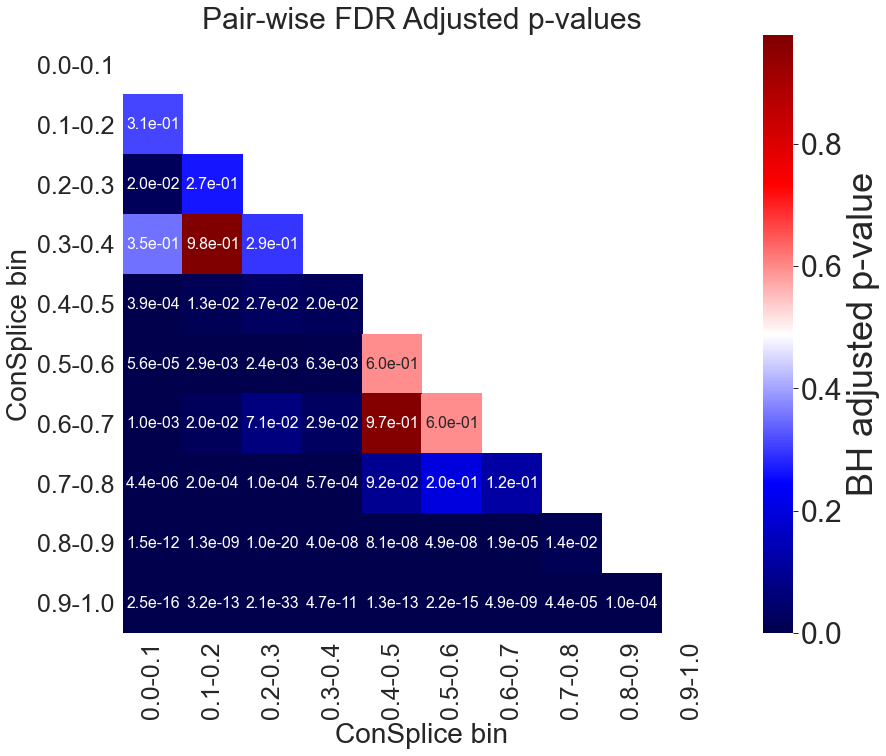

In [22]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (15,11))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 1.65)
sns.despine()

mask = np.triu(np.ones_like(temp_df))

sns.heatmap(temp_df, 
            mask = mask, 
            square=True, 
            cbar_kws={'label': "BH adjusted p-value"}, 
            annot=True,
            cmap="seismic",
            fmt=".1e")

ax.figure.axes[-1].yaxis.label.set_size(36)
ax.collections[0].colorbar.ax.tick_params(labelsize=30)

ax.set_ylabel("ConSplice bin", fontsize = 28)
ax.set_xlabel("ConSplice bin", fontsize = 28)
ax.set_title("Pair-wise FDR Adjusted p-values", fontsize = 30)

ax.tick_params(axis="x", labelsize=25, rotation=90)
ax.tick_params(axis="y", labelsize=25, rotation=0)

plt.savefig('../figures/suppl_figure5_C.svg')